# Анализ взаимодействия с клиентами сети фитнес-центров «Культурист-датасаентист»

Для проведения анализа используем существующий набор данных сети фитнес-центров «Культурист-датасаентист» в csv-файлах, чтобы определить, какова основная структура данных, выявить тенденции, проверить гипотезы и подготовить план действий по удержанию клиентов.  А именно: 
 - научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
 - сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
 - проанализировать основные признаки, наиболее сильно влияющие на отток;
 - сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
1) выделить целевые группы клиентов;
2) предложить меры по снижению оттока;
3) определить другие особенности взаимодействия с клиентами.

Заказчик подготовил данные, которые содержат данные на месяц до оттока и факт оттока на определённый месяц.
   
Цель проекта: анализ данных интернет-магазина для уменьшения оттока клиентов.
    
Задачи проекта: исследовательский анализ данных (EDA), бинарная классификация и кластеризация объектов (клиентов), анализ результатов.

Подготовка данных для процесса анализа включает в себя: извлечение данных, их очистка и преобразование. Следующий важный этап - изучение данных в графической или статистической репрезентации с целью поиска моделей или взаимосвязей, после чего приступим непосредственно к анализу, а затем к интерпретации результатов и принятию решения.

## Шаг 1. Загрузка данных

In [1]:
# импорт библиотек
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.cluster import KMeans
import itertools
from scipy.cluster.hierarchy import dendrogram, linkage 

In [2]:
# чтение файлов с данными и сохранение в gym_churn
try: # яндексовский путь
    gym_churn = pd.read_csv('/datasets/gym_churn.csv')
except: # мой путь
    gym_churn = pd.read_csv('/content/hypothesis.csv')

## Шаг 2. Предобработка данных (исследовательский анализ данных (EDA))

In [3]:
# размер датасета
print(gym_churn.shape)

(4000, 14)


In [4]:
# получение первых 10 строк таблицы gym_churn
gym_churn.head(10)

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0
5,1,1,0,0,1,1,1,34,450.743960,1.0,3,2.623477,2.637007,0
6,1,1,1,1,0,6,1,32,94.266389,6.0,2,1.138941,1.277242,0
7,0,1,0,0,1,1,0,30,217.786641,1.0,0,1.213502,1.049387,1
8,1,1,1,1,1,1,1,23,45.409909,1.0,1,1.106239,1.059333,0
9,0,1,0,0,1,1,0,31,65.310836,1.0,11,1.810852,1.951368,0


In [5]:
# получение общей информации о данных в таблице gym_churn
gym_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

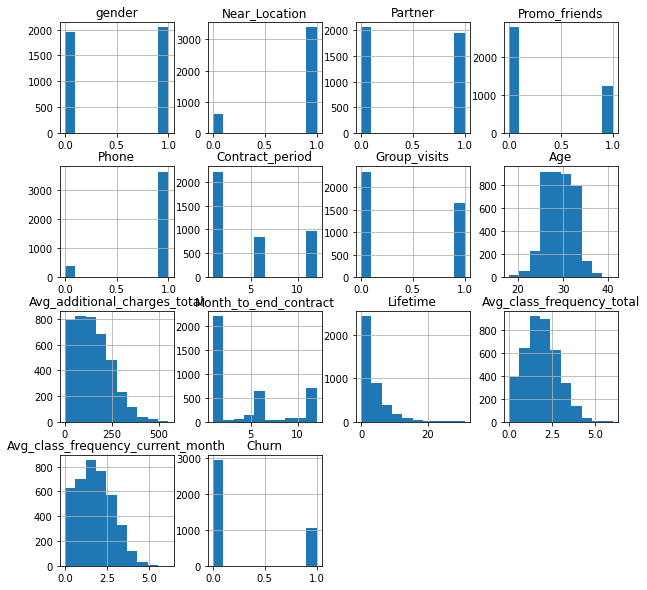

In [6]:
# общая гистограмма
gym_churn.hist(figsize=(10, 10))
plt.show() # добавила для корректного вывода графиков

Каких-то ярких выбросов и перекосов не наблюдается.

In [7]:
# перевод названий столбцов в snake_case
# gym_churn.columns = [x.lower() for x in gym_churn.columns] #альтернативный метод
gym_churn.columns = gym_churn.columns.str.lower()

In [8]:
# изменение типа данных
#for column in ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits', 'churn']:
#    gym_churn[column] = gym_churn[column].astype(bool)

#gym_churn['month_to_end_contract'] = gym_churn['month_to_end_contract'].astype(int)

In [9]:
# проверка наличия явных дубликатов
gym_churn.duplicated().sum()

0

In [10]:
# изучим статистические характеристики по числовому признаку
gym_churn.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


Большинство клиентов - женщины, большая часть живет в непосредственной близости от фитнес-центров, об этом говорит высокое среднее и низкое стандартное отклонение. Половина клиентов пришла по партнерским программам, среди клиентов довольно мало тех, кто пришел по акции "приведи друга", почти у всех указан номер телефона, менее половины посещают групповые занятия. Средний возраст клиента составляет 29 лет. Абонементы быват от 1 до 12 месяцев и судя по стандартному отклонению разброс этих абонементов довольно большой. То же касается и срока окончания действия абонементов. Есть клиенты, которые еще ни разу не успели посетить занятия и те, кто занимается уже более 2 лет. Есть клиенты, которые занимаются по 6 раз в неделю, но в среднем это 1-2 посещения в неделю. Максимальная выручка с дополнительных услуг в центрах более 500 единиц, в среднем 147. Отток, на первый взгляд, не выглядит критичным, в среднем около 26%.

In [11]:
# средние значения признаков в двух группах — тех, кто ушел в отток(1) и тех, кто остался(0)
gym_churn.groupby('churn').mean().T

churn,0,1
gender,0.510037,0.510839
near_location,0.873086,0.768143
partner,0.534195,0.355325
promo_friends,0.353522,0.183789
phone,0.903709,0.902922
contract_period,5.747193,1.728558
group_visits,0.464103,0.268615
age,29.976523,26.989632
avg_additional_charges_total,158.445715,115.082899
month_to_end_contract,5.283089,1.662582


В оттоке пол не оказывает сильного влияния, тут клиенты, которые чаще живут не в непосредственной близости к клубу, пришедшие не по партнерской скидочной программе, которые реже посещают групповые занятия, в среднем занимаются около месяца.

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


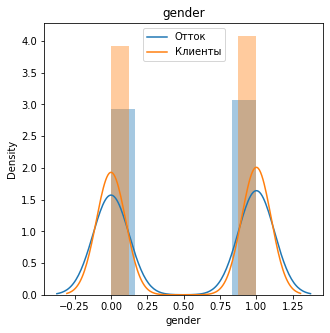

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


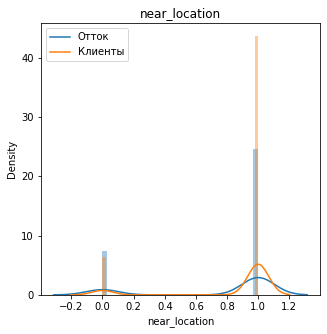

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


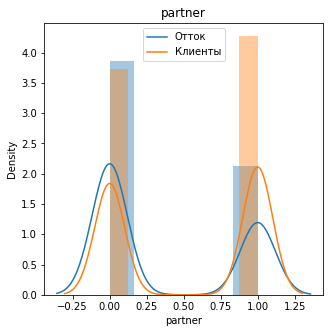

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


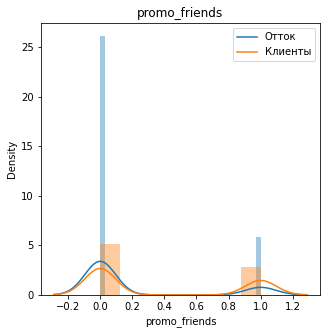

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


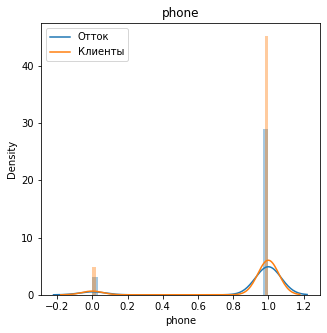

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


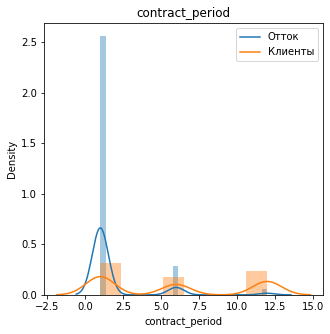

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


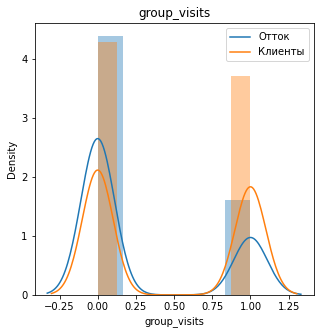

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


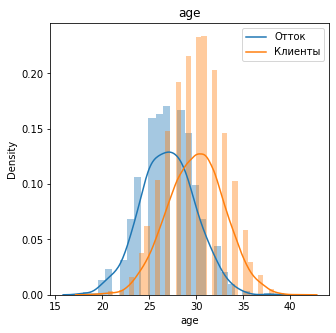

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


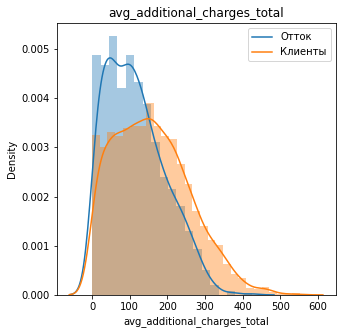

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


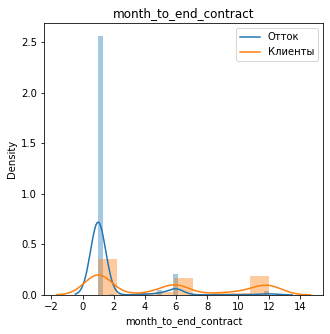

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


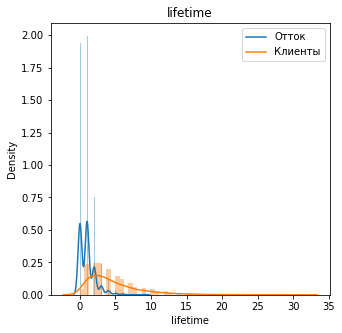

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


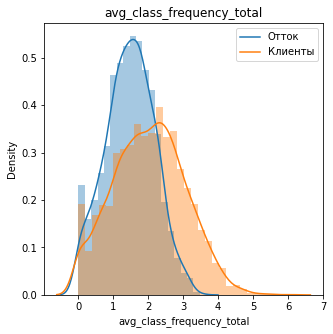

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


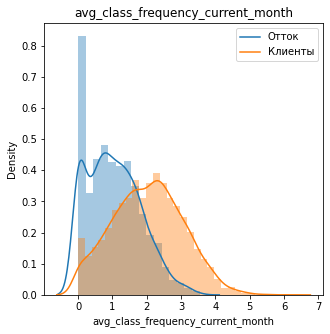

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate

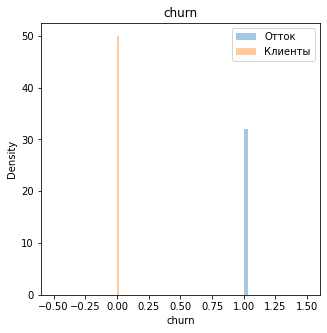

In [12]:
# построим столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток)
stopped_using = gym_churn[gym_churn['churn']==1]
customers = gym_churn[gym_churn['churn']==0]

for column in gym_churn.columns:
    plt.figure(figsize=(5, 5))
    sns.distplot(stopped_using[column])
    sns.distplot(customers[column])
    plt.legend(['Отток', 'Клиенты'])
    plt.title(column)
    plt.show()
    
warnings.simplefilter(action='ignore') # отключила warnings

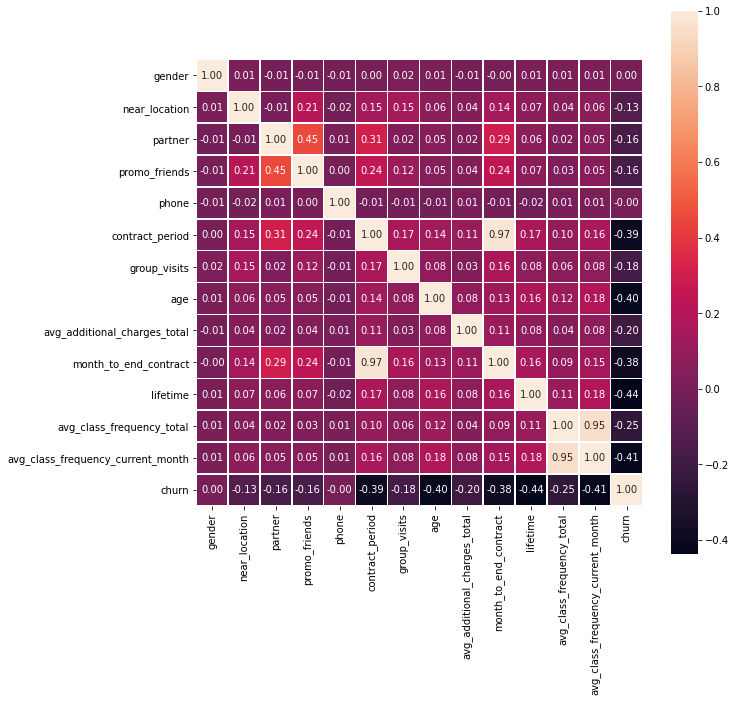

In [13]:
#построим и отрисуем матрицу корреляций
cm = gym_churn.corr() #вычисляем матрицу корреляций
plt.figure(figsize=(10, 10))
#fig, ax = plt.subplots()

#нарисуем тепловую карту с подписями для матрицы корреляций
sns.heatmap (cm, annot=True, square=True, fmt = '0.2f', linewidths=.5) #ваш код здесь
#ax.set_ylim(
#    7, 0
#)  # корректировка "рваных" полей heatmap в последней версии библиотеки
plt.show()

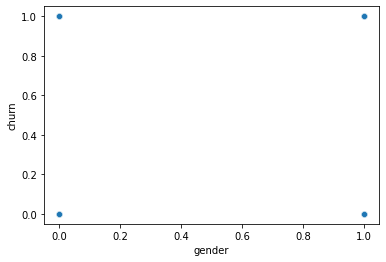

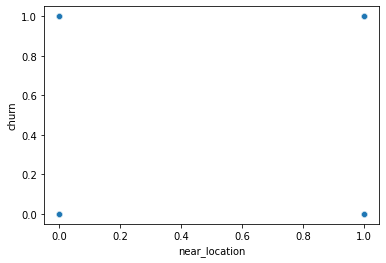

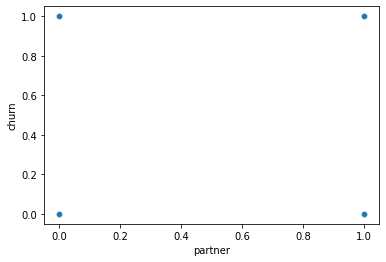

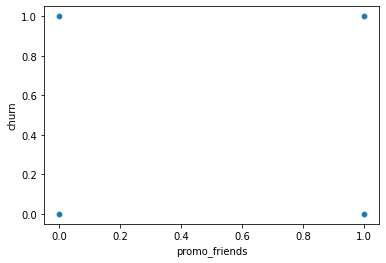

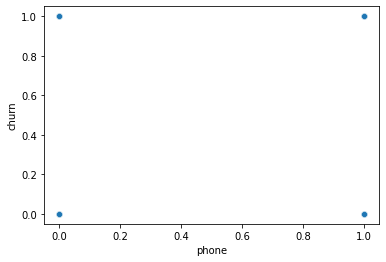

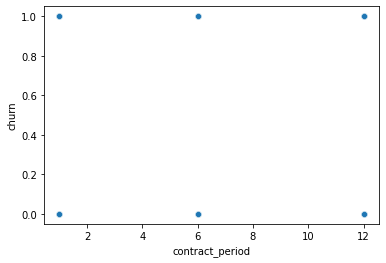

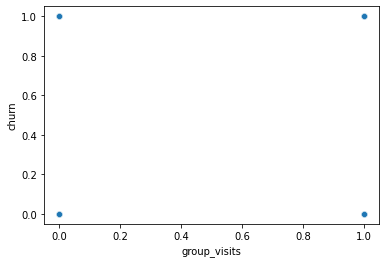

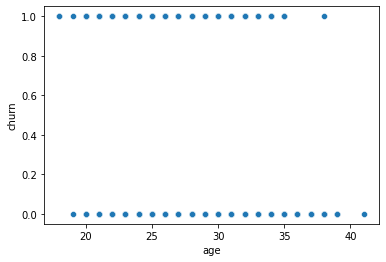

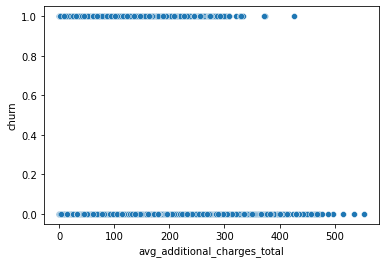

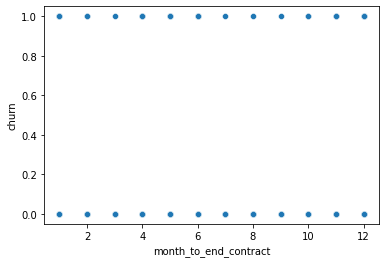

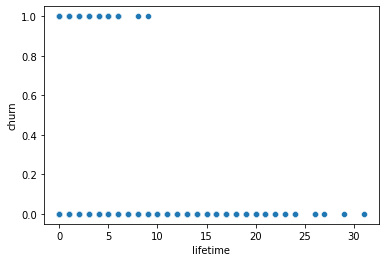

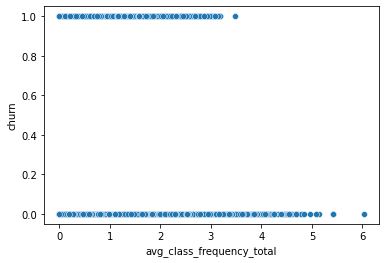

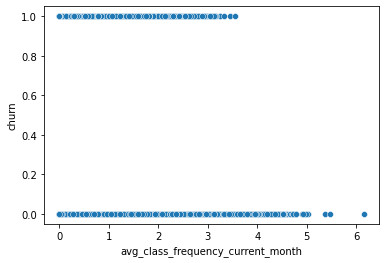

In [14]:
#построим попарные диаграммы рассеяния признак-целевая переменная для каждого признака
for col in gym_churn.drop('churn', axis = 1).columns:
    sns.scatterplot(x=gym_churn[col], y=gym_churn['churn'])
    plt.show()

Что касается корреляций и попарных графиков — можно заметить, что некоторые признаки коррелируют друг с другом: contract_period и month_to_end_contract, avg_class_frequency_current_month и avg_class_frequency_total. Есть признаки с нулевой корреляцией с целевой переменной, это phone и gender, они вообще никак не влияют на отток. Наиболее сильно влияют на отток: время с момента первого обращения в фитнес-центр, количество посещений в месяц, возраст, длительность текущего действующего абонемента.

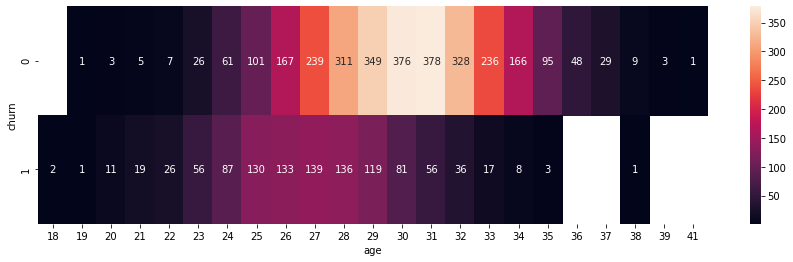

In [15]:
# количество клиентов по возрасту среди тех, кто ушел в отток(1) и тех, кто остался(0)
df = gym_churn.pivot_table(index='churn',columns='age', values='month_to_end_contract', aggfunc='count')
plt.figure(figsize=(15, 4))
sns.heatmap(df, annot=True, fmt='.0f')
plt.show()

Итак, **в таблице gym_churn** 14 столбцов. Типы данных в столбцах: int64, float64.
Согласно документации набор данных включает следующие поля:

* Данные клиента за предыдущий до проверки факта оттока месяц:
    * `gender` — пол;
    * `Near_Location` — проживание или работа в районе, где находится фитнес-центр;
    * `Partner` — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
    * `Promo_friends` — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
    * `Phone` — наличие контактного телефона;
    * `Age` — возраст;
    * `Lifetime` — время с момента первого обращения в фитнес-центр (в месяцах).

* Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
    * `Contract_period` — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
    * `Month_to_end_contract` — срок до окончания текущего действующего абонемента (в месяцах);
    * `Group_visits` — факт посещения групповых занятий;
    * `Avg_class_frequency_total` — средняя частота посещений в неделю за все время с начала действия абонемента;
    * `Avg_class_frequency_current_month` — средняя частота посещений в неделю за предыдущий месяц;
    * `Avg_additional_charges_total` — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.

* `Churn` — факт оттока в текущем месяце.

Выгрузка совершена корректно, количество значений в столбцах не различается, пропусков и явных дубликатов нет.

Средний возраст клиента 29 лет и возрастной признак сильно коррелирует с оттоком, в отток попадают более молодые клиенты. Так же ключевыми переменными являются: время с момента первого обращения в фитнес-центр, количество посещений в месяц, длительность текущего действующего абонемента.

## Шаг 3. Модель прогнозирования оттока клиентов

In [16]:
# построим модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце:
# разделим данные на обучающую и валидационную выборку функцией train_test_split().
# обучим модель на train-выборке двумя способами: логистической регрессией и случайным лесом

In [21]:
# разделим наши данные на признаки (матрица X) и целевую переменную (y)
X = gym_churn.drop('churn', axis = 1)
y = gym_churn['churn']

# разделим модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# масштабируем данные
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)
X_test_st = scaler.transform(X_test)

# зададим алгоритм для нашей модели
lr_model = LogisticRegression(solver='liblinear')

# обучим модель
lr_model.fit(X_train_st, y_train)

# воспользуемся уже обученной моделью, чтобы сделать прогнозы
predictions = lr_model.predict(X_test_st)
probabilities = lr_model.predict_proba(X_test_st)[:,1]

# выведем все изученные метрики для полученного прогноза
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, predictions)))
print('Precision: {:.2f}'.format(precision_score (y_test, predictions)))
print('Recall: {:.2f}'.format(recall_score (y_test, predictions)))
print('F1: {:.2f}'.format(f1_score(y_test, predictions)))

Accuracy: 0.92
Precision: 0.85
Recall: 0.83
F1: 0.84


In [20]:
# случайный лес

rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0, class_weight='balanced') 
rf_model.fit(X_train, y_train)

rf_predictions = rf_model.predict(X_test) 
rf_probabilities = rf_model.predict_proba(X_test)[:,1]

print('Accuracy: {:.2f}'.format(accuracy_score(y_test, rf_predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, rf_predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, rf_predictions)))
print('F1: {:.2f}'.format(f1_score(y_test, rf_predictions)))  

Accuracy: 0.91
Precision: 0.84
Recall: 0.79
F1: 0.81


Доля правильных прогнозов и полнота чуть выше в модели логистической регрессии. Таким образом, модель логистической регрессии показала себя лучше.

## Шаг 4. Кластеризация клиентов

In [ ]:
# стандартизируем данные
sc = StandardScaler()
x_sc = sc.fit_transform(gym_churn)

In [ ]:
# построим матрицу расстояний функцией linkage() на стандартизованной матрице признаков и нарисуем дендрограмму
linked = linkage(x_sc, method = 'ward') 
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Иерархическая кластеризация клиентов')
plt.show() 

Предложенное оптимальное число кластеров 5 — пять разных цветов на графике. По заданию также за число кластеров принимаем n=5.

In [ ]:
# задаём модель k_means с числом кластеров 5 и фиксируем значение random_state
km = KMeans(n_clusters=5, random_state=0)
# прогнозируем кластеры для наблюдений (алгоритм присваивает им номера от 0 до 4)
labels = km.fit_predict(x_sc)

# сохраняем метки кластера в поле нашего датасета
gym_churn['cluster_km'] = labels

In [ ]:
# выводим статистику по средним значениям наших признаков по кластеру
gym_churn.groupby('cluster_km').mean().T

In [ ]:
# посчитаем количество клиентов по кластерам
gym_churn.groupby('cluster_km')['churn'].count().reset_index().sort_values(by='churn', ascending=False)

Самый большой отток во 2 кластере - 96%, затем в нулевом - 45%. В третьем кластере самый маленький отток и самая большая численность клиентов.

In [ ]:
# распределения бинарных признаков для кластеров
for column in ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits']:
    plt.figure(figsize=(5, 5))
    sns.countplot(x = gym_churn[column], hue='cluster_km', data=gym_churn)
    plt.title(column)
    plt.show()

In [ ]:
# распределения признаков для кластеров
cluster_0 = gym_churn[gym_churn['cluster_km']==0]
cluster_1 = gym_churn[gym_churn['cluster_km']==1]
cluster_2 = gym_churn[gym_churn['cluster_km']==2]
cluster_3 = gym_churn[gym_churn['cluster_km']==3]
cluster_4 = gym_churn[gym_churn['cluster_km']==4]

for column in gym_churn.columns:
    plt.figure(figsize=(5, 5))
    sns.distplot(cluster_0[column])
    sns.distplot(cluster_1[column])
    sns.distplot(cluster_2[column])
    sns.distplot(cluster_3[column])
    sns.distplot(cluster_4[column])
    plt.legend(['кластер 0', 'кластер 1', 'кластер 2', 'кластер 3', 'кластер 4'])
    plt.title(column)
    plt.show()
    
warnings.simplefilter(action='ignore') # отключила warnings

In [ ]:
# посчитаем долю оттока для каждого полученного кластера  
gym_churn.groupby('cluster_km')['churn'].mean().reset_index().sort_values(by='churn', ascending=False)

Самый большой отток во втором кластере - 96%, затем в нулевом - 45%. Третий кластер выглядит самым надежным - в нем маленький отток.

### Выводы

Рекомендации для стратегии взаимодействия с клиентами и их удержания:
 - получение голосовой обратной связи с клиентами о том, решает ли продукт проблемы клиентов или вызывает проблемы: взаимодействие с клиентами через телефонный звонок, электронную почту или опрос;
 - идентификация клиентов в зоне риска (мужчины/женщины моложе 29 лет, проживающие не в непосредственной близости к клубу, пришедшие не по партнерской скидочной программе, которые реже посещают групповые занятия, в среднем занимаются около месяца);
 - определение самых ценных клиентов и максимальные усилия для их удержания;
 - предложение стимулов и скидок.